In [1]:
%matplotlib inline
import requests
from datetime import datetime
from matplotlib import pyplot as plt
from IPython.display import display, HTML
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from numba import guvectorize
from scipy import signal
from scipy import stats as ss

In [2]:
# utils functions
# ===============

def get_prices(coin_symbol):
    """Get close price.

    Given a symbol crytocurrency retrieve last 2k close prices in USD.

    Parameters
    ----------
    coin_symbol : str

    Returns
    -------
    price_close : pandas.DataFrame
    """
    endpoint = "https://min-api.cryptocompare.com/data/histoday"
    params = dict(fsym=coin_symbol, tsym="BTC",limit=2000, aggregate=1)
    out = requests.get(endpoint, params=params).json()['Data']
    data = pd.DataFrame(out).set_index('time')\
                            .loc[:, ['close']]\
                            .rename(columns=dict(close=coin_symbol))
    return data

In [3]:
def get_symbol_close(coin_symbol_list):
    """Get symbol close.

    Given a list of cryptocurrencies symbols retrieve close prices.

    Parameters
    ----------
    coin_symbol_list : list

    Returns
    -------
    price_close : pandas.DataFrame
    """
    d = [get_prices(coin_sym) for coin_sym in coin_symbol_list]
    out = pd.concat(d, axis=1)
    out.index = out.index.map(datetime.utcfromtimestamp)
    return out.asfreq(out.index.inferred_freq)


def multi_column_df_display(list_dfs, cols=3):
    html_table = "<table style='width:100%; border:0px'>{content}</table>"
    html_row = "<tr style='border:0px'>{content}</tr>"
    html_cell = "<td style='width:{width}%;vertical-align:top;border:0px'>{{content}}</td>"
    html_cell = html_cell.format(width=100/cols)
    cells = [html_cell.format(content=df.to_html()) for df in list_dfs]
    cells += (cols - (len(list_dfs) % cols)) * [html_cell.format(content="")]
    rows = [html_row.format(content="".join(cells[i:i+cols])) for i in range(0, len(cells), cols)]
    display(HTML(html_table.format(content="".join(rows))))

In [4]:
# hurst functions
# ===============
@guvectorize("float64[:], int64, int64, int64, float64[:]", "(m),(),(),()->()",
             cache=True, nopython=True)
def hurst_rs(x, min_chunksize, max_chunksize, num_chunksize, out):
    """Estimate the Hurst exponent using R/S method.

    Estimates the Hurst (H) exponent using the R/S method from the time series.
    The R/S method consists of dividing the series into pieces of equal size
    `series_len` and calculating the rescaled range. This repeats the process
    for several `series_len` values and adjusts data regression to obtain the H.
    `series_len` will take values between `min_chunksize` and `max_chunksize`,
    the step size from `min_chunksize` to `max_chunksize` can be controlled
    through the parameter `step_chunksize`.

    Parameters
    ----------
    x : 1D-array
        A time series to calculate hurst exponent, must have more elements
        than `min_chunksize` and `max_chunksize`.
    min_chunksize : int
        This parameter allow you control the minimum window size.
    max_chunksize : int
        This parameter allow you control the maximum window size.
    num_chunksize : int
        This parameter allow you control the size of the step from minimum to
        maximum window size. Bigger step means fewer calculations.
    out : 1-element-array, optional
        one element array to store the output.

    Returns
    -------
    H : float
        A estimation of Hurst exponent.

    References
    ----------
    Hurst, H. E. (1951). Long term storage capacity of reservoirs. ASCE
    Transactions, 116(776), 770-808.
    Alessio, E., Carbone, A., Castelli, G. et al. Eur. Phys. J. B (2002) 27:
    197. http://dx.doi.org/10.1140/epjb/e20020150
    """
    N = len(x)
    max_chunksize += 1
    rs_tmp = np.empty(N, dtype=np.float64)
    chunk_size_list = np.linspace(min_chunksize, max_chunksize, num_chunksize)\
                        .astype(np.int64)
    rs_values_list = np.empty(num_chunksize, dtype=np.float64)

    # 1. The series is divided into chunks of chunk_size_list size
    for i in range(num_chunksize):
        chunk_size = chunk_size_list[i]

        # 2. it iterates on the indices of the first observation of each chunk
        number_of_chunks = int(len(x) / chunk_size)

        for idx in range(number_of_chunks):
            # next means no overlapping
            # convert index to index selection of each chunk
            ini = idx * chunk_size
            end = ini + chunk_size
            chunk = x[ini:end]

            # 2.1 Calculate the RS (chunk_size)
            z = np.cumsum(chunk - np.mean(chunk))
            rs_tmp[idx] = np.divide(
                np.max(z) - np.min(z),  # range
                np.nanstd(chunk)  # standar deviation
            )

        # 3. Average of RS(chunk_size)
        rs_values_list[i] = np.nanmean(rs_tmp[:idx + 1])

    # 4. calculate the Hurst exponent.
    H, c = np.linalg.lstsq(
        a=np.vstack((np.log(chunk_size_list), np.ones(num_chunksize))).T,
        b=np.log(rs_values_list)
    )[0]

    out[0] = H

In [5]:
def hurst_dma(prices, min_chunksize=8, max_chunksize=200, num_chunksize=5):
    """Estimate the Hurst exponent using R/S method.

    Estimates the Hurst (H) exponent using the DMA method from the time series.
    The DMA method consists on calculate the moving average of size `series_len`
    and subtract it to the original series and calculating the standard
    deviation of that result. This repeats the process for several `series_len`
    values and adjusts data regression to obtain the H. `series_len` will take
    values between `min_chunksize` and `max_chunksize`, the step size from
    `min_chunksize` to `max_chunksize` can be controlled through the parameter
    `step_chunksize`.

    Parameters
    ----------
    prices
    min_chunksize
    max_chunksize
    num_chunksize

    Returns
    -------
    hurst_exponent : float
        Estimation of hurst exponent.

    References
    ----------
    Alessio, E., Carbone, A., Castelli, G. et al. Eur. Phys. J. B (2002) 27:
    197. http://dx.doi.org/10.1140/epjb/e20020150

    """
    max_chunksize += 1
    N = len(prices)
    n_list = np.arange(min_chunksize, max_chunksize, num_chunksize, dtype=np.int64)
    dma_list = np.empty(len(n_list))
    factor = 1 / (N - max_chunksize)
    # sweeping n_list
    for i, n in enumerate(n_list):
        b = np.divide([n - 1] + (n - 1) * [-1], n)  # do the same as:  y - y_ma_n
        noise = np.power(signal.lfilter(b, 1, prices)[max_chunksize:], 2)
        dma_list[i] = np.sqrt(factor * np.sum(noise))

    H, const = np.linalg.lstsq(
        a=np.vstack([np.log10(n_list), np.ones(len(n_list))]).T,
        b=np.log10(dma_list)
    )[0]
    return H

In [6]:
def hurst_dsod(x):
    """Estimate Hurst exponent on data timeseries.

    The estimation is based on the discrete second order derivative. Consists on
    get two different noise of the original series and calculate the standard
    deviation and calculate the slope of two point with that values.
    source: https://gist.github.com/wmvanvliet/d883c3fe1402c7ced6fc

    Parameters
    ----------
    x : numpy array
        time series to estimate the Hurst exponent for.

    Returns
    -------
    h : float
        The estimation of the Hurst exponent for the given time series.

    References
    ----------
    Istas, J.; G. Lang (1994), “Quadratic variations and estimation of the local
    Hölder index of data Gaussian process,” Ann. Inst. Poincaré, 33, pp. 407–436.


    Notes
    -----
    This hurst_ets is data literal traduction of wfbmesti.m of waveleet toolbox
    from matlab.
    """
    y = np.cumsum(np.diff(x, axis=0), axis=0)

    # second order derivative
    b1 = [1, -2, 1]
    y1 = signal.lfilter(b1, 1, y, axis=0)
    y1 = y1[len(b1) - 1:]  # first values contain filter artifacts

    # wider second order derivative
    b2 = [1,  0, -2, 0, 1]
    y2 = signal.lfilter(b2, 1, y, axis=0)
    y2 = y2[len(b2) - 1:]  # first values contain filter artifacts

    s1 = np.mean(y1 ** 2, axis=0)
    s2 = np.mean(y2 ** 2, axis=0)

    return 0.5 * np.log2(s2 / s1)

In [7]:
def hurst_exponent(prices, min_chunksize=8, max_chunksize=200, num_chunksize=5,
                   method='RS'):
    """Estimates Hurst Exponent.

    Estimate the hurst exponent following one of 3 methods. Each method

    Parameters
    ----------
    prices : numpy.ndarray, pandas.Series or pandas.DataFrame
        A time series to estimate hurst exponent.
    min_chunksize : int, optional
        Minimum chunk  size of the original series. This parameter doesn't have
        any effect with DSOD method.
    max_chunksize : int, optional
        Maximum chunk size of the original series. This parameter doesn't have
        any effect with DSOD method.
    step_chunksize : int, optional
        Step used to select next the chunk size which divide the original
        series. This parameter doesn't have any effect with DSOD method.
    method : {'RS', 'DMA', 'DSOD', 'all'}
        The methods can take one of that values,
            RS : rescaled range.
            DMA : deviation moving average.
            DSOD : discrete second order derivative.


    Returns
    -------
    hurst_exponent : float
        Estimation of hurst_exponent according to the method selected.

    References
    ----------
    RS : Hurst, H. E. (1951). Long term storage capacity of reservoirs. ASCE
         Transactions, 116(776), 770-808.
    DMA : Alessio, E., Carbone, A., Castelli, G. et al. Eur. Phys. J. B (2002)
         27: 197. http://dx.doi.org/10.1140/epjb/e20020150
    DSOD : Istas, J.; G. Lang (1994), “Quadratic variations and estimation of
        the local Hölder index of data Gaussian process,” Ann. Inst. Poincaré,
        33, pp. 407–436.

    Notes
    -----
    The hurst exponent is an estimation which is important because there is no
    data closed equation for it instead we have some methods to estimate it with
    high variations among them.

    See Also
    --------
    hurst_rs, hurst_dma, hurst_dsod
    """
    if len(prices) == 0:
        return np.nan
    # extract array
    arr = prices.__array__()
    # choose data method
    if method == 'RS':
        if prices.ndim > 1:
            h = hurst_rs(np.diff(arr, axis=0).T, min_chunksize, max_chunksize,
                         num_chunksize)
        else:
            h = hurst_rs(np.diff(arr), min_chunksize, max_chunksize,
                         num_chunksize)
    elif method == 'DMA':
        h = hurst_dma(arr, min_chunksize, max_chunksize, num_chunksize)
    elif method == 'DSOD':
        h = hurst_dsod(arr)
    elif method == 'all':
        return [
            hurst_exponent(arr, min_chunksize, max_chunksize, num_chunksize, 'RS'),
            hurst_exponent(arr, min_chunksize, max_chunksize, num_chunksize, 'DMA'),
            hurst_exponent(arr, min_chunksize, max_chunksize, num_chunksize, 'DSOD')
        ]
    else:
        raise NotImplementedError('The method choose is not implemented.')
    
    return h

To show about about persistence we can follow similiar steps as shown in the paper [Persistence in the cryptocurrency market](https://www.sciencedirect.com/science/article/pii/S0275531917309200). I select the same four currencies selected in that paper, that is: Bitcoin, Ethereum, Dash and Litecoin.

You can see [here](https://coinmarketcap.com/coins/) the top crypto currencies by market capitalization.

In [8]:
coin_sym_list = 'ETH DASH LTC'.split()
prices = get_symbol_close(coin_sym_list)
prices = prices.loc['2014':]  # select the same period
prices = prices.where(prices != 0., np.nan)  # convert zeros into NaN's

In [9]:
multi_column_df_display([prices.head(), prices.tail()], 2)

,ETH,DASH,LTC
time,,,
2014-01-01,NaN,NaN,0.0320
2014-01-02,NaN,NaN,0.0323
2014-01-03,NaN,NaN,0.0304
2014-01-04,NaN,NaN,0.0298
2014-01-05,NaN,NaN,0.0293
,ETH,DASH,LTC
time,,,
2018-09-24,0.03464,0.03009,0.008813
2018-09-25,0.03402,0.02952,0.008928


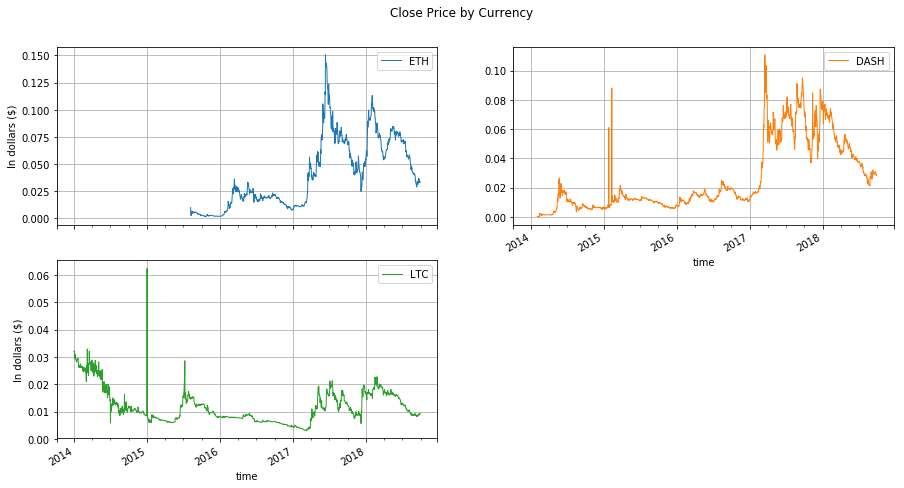

In [10]:
# plot price series
kw = dict(figsize=(15,8), grid=True, subplots=True, layout=(2,2), linewidth=1)
axs = prices.plot(**kw)
[ax.set_ylabel('In dollars ($)') for ax in axs.flat[::2]]
plt.suptitle('Close Price by Currency', y=0.95);

In [11]:
# table hurst with entire series
hurst_methods = [
    prices.apply(lambda x: hurst_exponent(x.dropna(), method='DSOD')),
    prices.apply(lambda x: hurst_exponent(x.dropna(), method='RS')),
    prices.apply(lambda x: hurst_exponent(x.dropna(), method='DMA')),
]
hurst_table = pd.concat(hurst_methods, axis=1)
hurst_table.columns = ['DSOD', 'RS', 'DMA']
hurst_table

/Users/noahmitsuhashi/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10
/Users/noahmitsuhashi/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:44: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


,DSOD,RS,DMA
ETH,0.448945,0.641815,NaN
DASH,0.181434,0.576430,NaN
LTC,0.084733,0.544317,NaN


In [12]:
# the same methodology as shown in the paper.
roll_days = 400
roll_prices = prices.rolling(roll_days)
summary = [
    roll_prices.apply(lambda s: hurst_exponent(s, method='RS')),
    roll_prices.apply(lambda s: hurst_exponent(s, method='DSOD')),
    ]
roll_hurst = pd.concat(summary, axis=1, keys=['RS', 'DSOD'])
roll_hurst = roll_hurst.swaplevel(axis=1)\
                       .asfreq(roll_hurst.index.inferred_freq)\
                       .sort_index(axis=1, level=0)

/Users/noahmitsuhashi/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """
/Users/noahmitsuhashi/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  


In [13]:
roll_hurst[::10].tail()

DASH                 ETH                 LTC          
                DSOD        RS      DSOD        RS      DSOD        RS
time                                                                  
2018-08-18  0.487171  0.510169  0.555445  0.682669  0.600487  0.560013
2018-08-28  0.480523  0.477230  0.549793  0.670836  0.623300  0.584976
2018-09-07  0.483431  0.506124  0.599377  0.703178  0.631443  0.574418
2018-09-17  0.472905  0.525733  0.592712  0.745328  0.626292  0.601729
2018-09-27  0.449212  0.507268  0.593974  0.742390  0.659355  0.601575

In [14]:
roll_hurst[::10].mean()

DASH  DSOD    0.393557
      RS      0.554569
ETH   DSOD    0.464243
      RS      0.620538
LTC   DSOD    0.356789
      RS      0.544247
dtype: float64

In [15]:
roll_hurst[::10].median()

DASH  DSOD    0.519354
      RS      0.564086
ETH   DSOD    0.442874
      RS      0.614053
LTC   DSOD    0.426399
      RS      0.562544
dtype: float64

In [16]:
roll_hurst[::10].mean(level=0, axis=1);

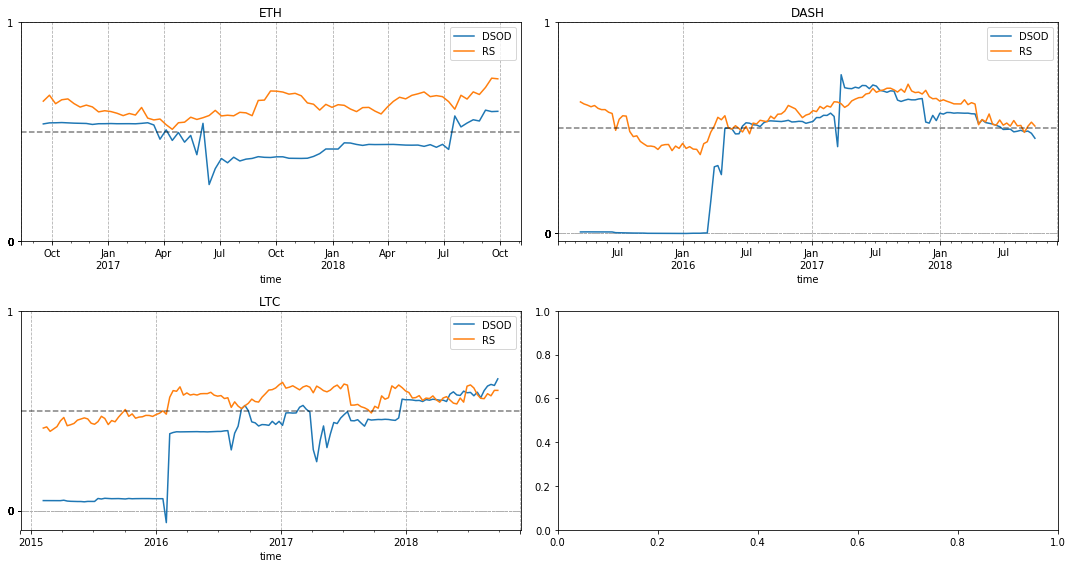

In [17]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin][::10].plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

In [18]:
# rather decimate the series we aliasing the seies.
ma_roll_hurst = roll_hurst.rolling(10).mean()
ma_roll_hurst.tail()

DASH                 ETH                 LTC          
                DSOD        RS      DSOD        RS      DSOD        RS
time                                                                  
2018-09-24  0.470848  0.520000  0.590136  0.739450  0.632090  0.604694
2018-09-25  0.469483  0.518145  0.590444  0.741597  0.635888  0.605550
2018-09-26  0.467627  0.517699  0.590579  0.741679  0.639256  0.604483
2018-09-27  0.465258  0.515852  0.590705  0.741385  0.642563  0.604468
2018-09-28  0.467740  0.514963  0.590973  0.740307  0.646188  0.602001

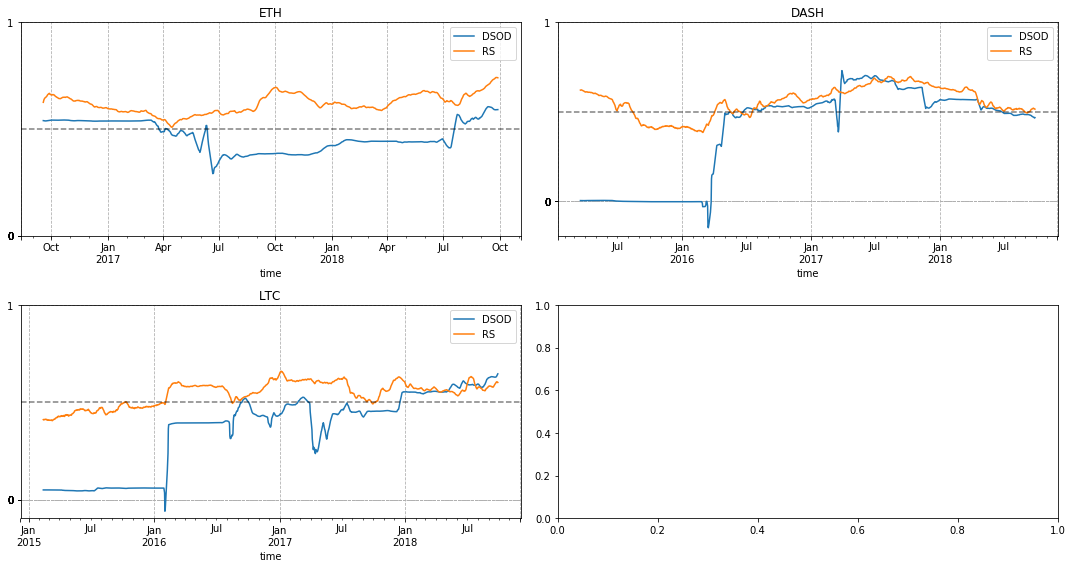

In [19]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin].rolling(10).mean().plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()    

In [20]:
roll_hurst[::20].tail()

DASH                 ETH                 LTC          
                DSOD        RS      DSOD        RS      DSOD        RS
time                                                                  
2018-06-29  0.491155  0.511454  0.443097  0.660974  0.589750  0.622704
2018-07-19  0.492654  0.506968  0.572850  0.603732  0.574578  0.613672
2018-08-08  0.482606  0.508426  0.540445  0.649930  0.564654  0.562029
2018-08-28  0.480523  0.477230  0.549793  0.670836  0.623300  0.584976
2018-09-17  0.472905  0.525733  0.592712  0.745328  0.626292  0.601729

In [21]:
roll_hurst[::20].mean()

DASH  DSOD    0.393011
      RS      0.552793
ETH   DSOD    0.459663
      RS      0.617342
LTC   DSOD    0.352442
      RS      0.545292
dtype: float64

In [22]:
roll_hurst[::20].median()

DASH  DSOD    0.520351
      RS      0.564650
ETH   DSOD    0.442874
      RS      0.612219
LTC   DSOD    0.426290
      RS      0.563323
dtype: float64

In [23]:
roll_hurst[::20].mean(level=0, axis=1);

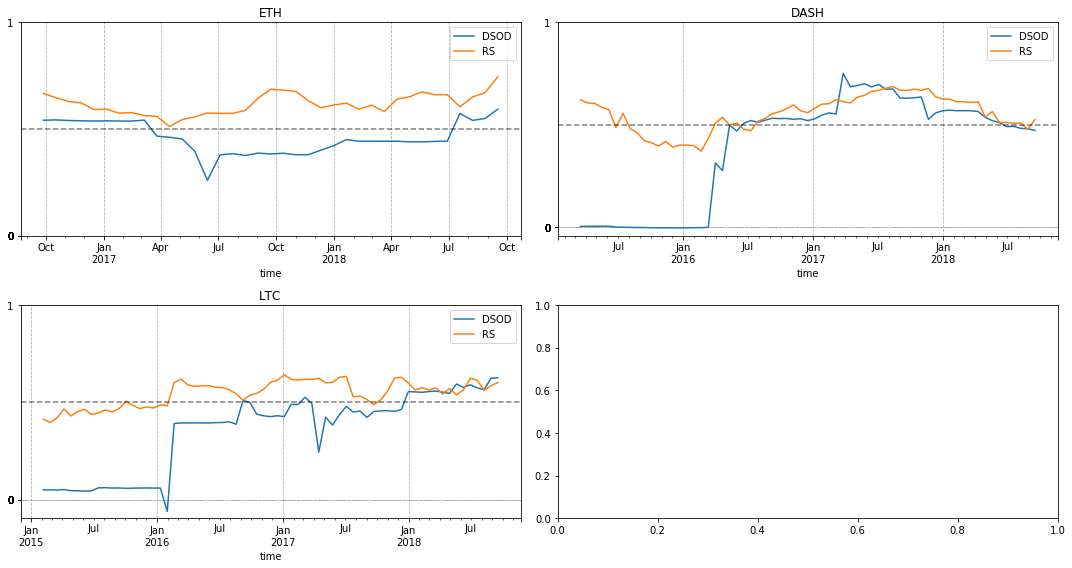

In [24]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin][::20].plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

In [25]:
# rather decimate the series we aliasing the seies.
ma_roll_hurst = roll_hurst.rolling(20).mean()
ma_roll_hurst.tail()

DASH                 ETH                 LTC          
                DSOD        RS      DSOD        RS      DSOD        RS
time                                                                  
2018-09-24  0.476662  0.510993  0.597113  0.725019  0.631539  0.591390
2018-09-25  0.475441  0.512609  0.596887  0.727369  0.633315  0.592171
2018-09-26  0.474153  0.513889  0.596752  0.729653  0.634893  0.593267
2018-09-27  0.472442  0.513946  0.596482  0.731614  0.636288  0.594625
2018-09-28  0.473009  0.514808  0.596023  0.732469  0.637884  0.595329

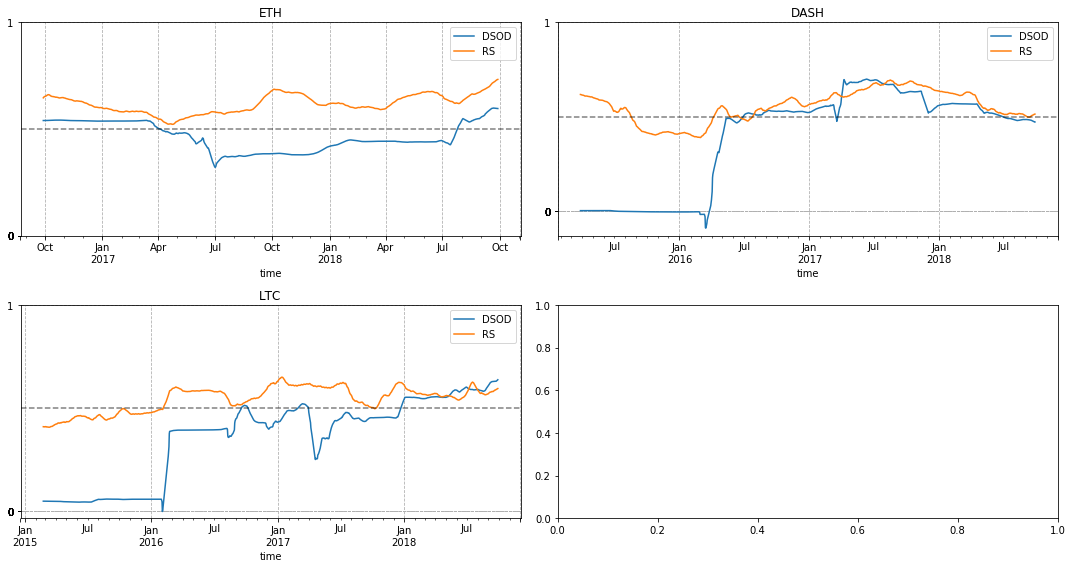

In [26]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin].rolling(20).mean().plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()    

In [27]:
roll_hurst[::30].tail()

DASH                 ETH                 LTC          
                DSOD        RS      DSOD        RS      DSOD        RS
time                                                                  
2018-05-10  0.523914  0.527119  0.439404  0.666885  0.582703  0.553308
2018-06-09  0.510697  0.511614  0.441732  0.661017  0.576306  0.563323
2018-07-09  0.492043  0.521538  0.419930  0.638191  0.591424  0.628973
2018-08-08  0.482606  0.508426  0.540445  0.649930  0.564654  0.562029
2018-09-07  0.483431  0.506124  0.599377  0.703178  0.631443  0.574418

In [28]:
roll_hurst[::30].mean()

DASH  DSOD    0.388494
      RS      0.553878
ETH   DSOD    0.457640
      RS      0.615513
LTC   DSOD    0.355679
      RS      0.545904
dtype: float64

In [29]:
roll_hurst[::30].median()

DASH  DSOD    0.513311
      RS      0.559165
ETH   DSOD    0.442755
      RS      0.613337
LTC   DSOD    0.430293
      RS      0.561401
dtype: float64

In [30]:
roll_hurst[::30].mean(level=0, axis=1);

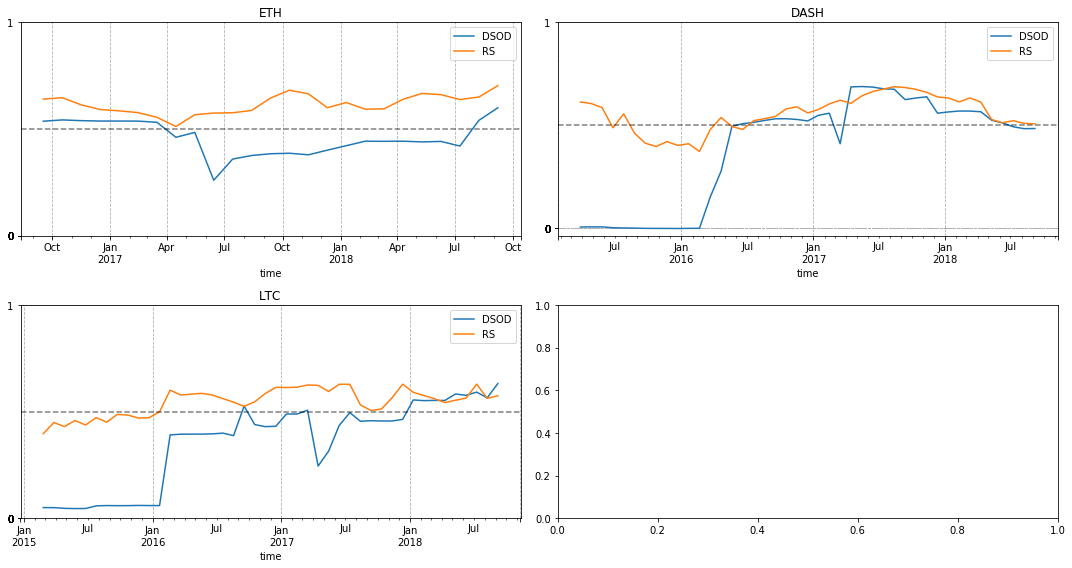

In [31]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin][::30].plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

In [32]:
# rather decimate the series we aliasing the seies.
ma_roll_hurst = roll_hurst.rolling(30).mean()
ma_roll_hurst.tail()

DASH                 ETH                 LTC          
                DSOD        RS      DSOD        RS      DSOD        RS
time                                                                  
2018-09-24  0.479326  0.505855  0.587995  0.712125  0.630255  0.588703
2018-09-25  0.478423  0.506370  0.589466  0.714424  0.631609  0.589502
2018-09-26  0.477664  0.506952  0.591044  0.716636  0.633034  0.590057
2018-09-27  0.476621  0.507954  0.592517  0.719022  0.634236  0.590610
2018-09-28  0.477121  0.508808  0.594338  0.721011  0.635713  0.591026

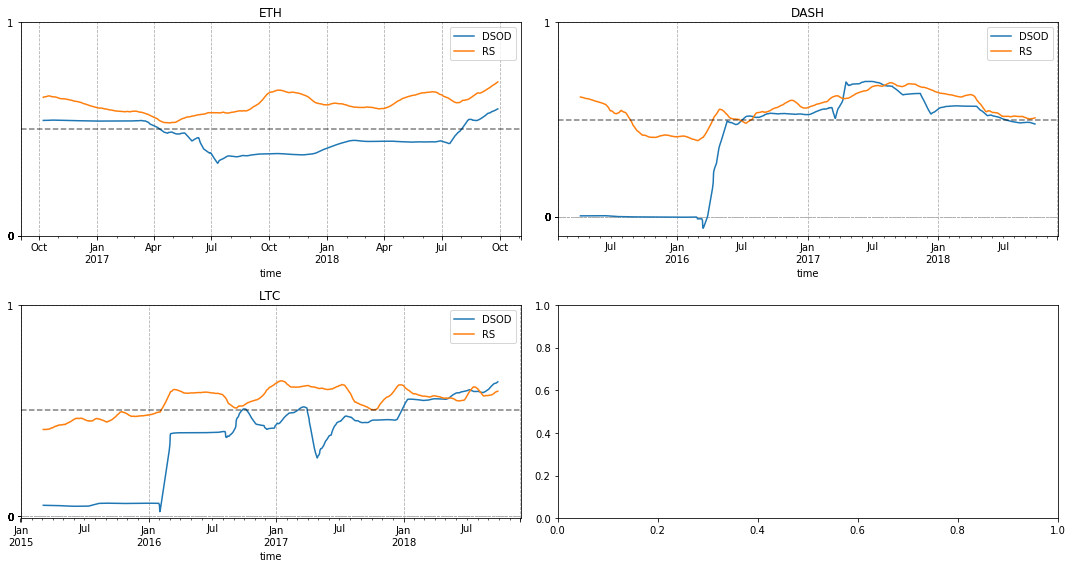

In [33]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin].rolling(30).mean().plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()    

In [34]:
roll_hurst[::50].tail()

DASH                 ETH                 LTC          
                DSOD        RS      DSOD        RS      DSOD        RS
time                                                                  
2018-02-09  0.568572  0.612781  0.442755  0.592686  0.551393  0.575325
2018-03-31  0.565784  0.618426  0.442379  0.613146  0.555225  0.554221
2018-05-20  0.520351  0.564650  0.439846  0.673983  0.594253  0.537864
2018-07-09  0.492043  0.521538  0.419930  0.638191  0.591424  0.628973
2018-08-28  0.480523  0.477230  0.549793  0.670836  0.623300  0.584976

In [35]:
roll_hurst[::50].mean()

DASH  DSOD    0.390094
      RS      0.556566
ETH   DSOD    0.468139
      RS      0.618089
LTC   DSOD    0.344929
      RS      0.541948
dtype: float64

In [36]:
roll_hurst[::50].median()

DASH  DSOD    0.513768
      RS      0.572711
ETH   DSOD    0.442755
      RS      0.613337
LTC   DSOD    0.426290
      RS      0.554221
dtype: float64

In [37]:
roll_hurst[::50].mean(level=0, axis=1);

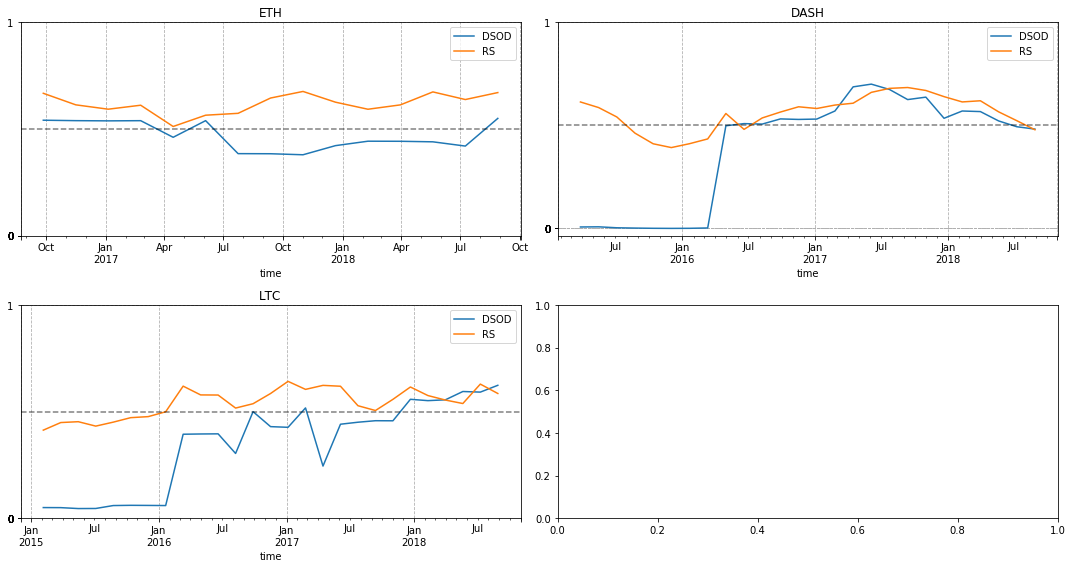

In [38]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin][::50].plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

In [39]:
# rather decimate the series we aliasing the seies.
ma_roll_hurst = roll_hurst.rolling(50).mean()
ma_roll_hurst.tail()

DASH                 ETH                 LTC          
                DSOD        RS      DSOD        RS      DSOD        RS
time                                                                  
2018-09-24  0.481901  0.509437  0.571570  0.694103  0.615528  0.579538
2018-09-25  0.481513  0.509039  0.572731  0.695984  0.617403  0.580302
2018-09-26  0.480982  0.509142  0.573871  0.697837  0.619261  0.580811
2018-09-27  0.480314  0.509119  0.574941  0.699686  0.621155  0.581602
2018-09-28  0.480508  0.509142  0.575934  0.701270  0.622840  0.581941

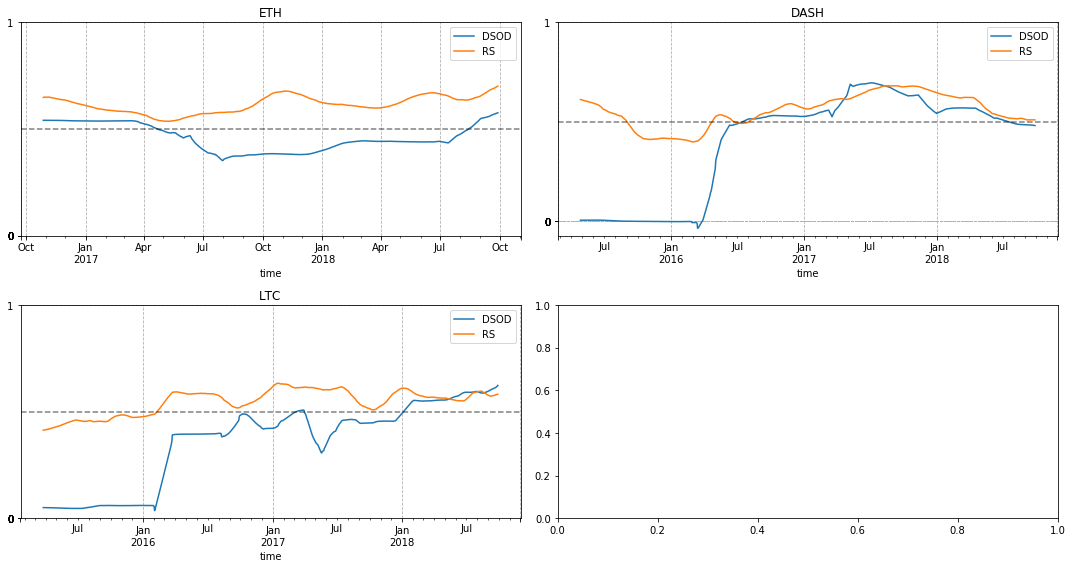

In [40]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin].rolling(50).mean().plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()    

# REFERENCES

- Caporale, G. M., Gil-Alana, L., & Plastun, A. (2017). Persistence in the Cryptocurrency Market. https://www.sciencedirect.com/science/article/pii/S0275531917309200
- H.E. Hurst, 1951, “Long-term storage of reservoirs: an experimental study,” Transactions of the American Society of Civil Engineers, Vol. 116, pp. 770-799.
- Bo Qian, Khaled Rasheed, 2004, “Hurst Exponent and financial market predictability,” IASTED conference on “Financial Engineering and Applications”(FEA 2004), pp. 203-209,
- Mandelbrot, Benoit B., 2004, “The (Mis)Behavior of Markets, A Fractal View of Risk, Ruin and Reward,” Basic Books, 2004.
